# Proyek Analisis Sentimen : Review Game Citampi Stories di Play Store (Modeling)
- **Nama:** Hafizha Aghnia Hasya
- **Email:** 	mc006d5x2114@student.devacademy.id
- **ID Dicoding:** MC006D5X2114

## Import Library

In [1]:
import numpy as np 
import pandas as pd
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
nltk.download('punkt')  # Untuk tokenisasi
nltk.download('stopwords')  # Untuk stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

import requests
import csv
from io import StringIO
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to C:\Users\Hafizha
[nltk_data]     Aghnia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Hafizha
[nltk_data]     Aghnia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
review = pd.read_csv('citampi_reviews.csv')

review.head()

,Review
0,"Mantepp bangett karya negara sendiri,smeangatt..."
1,gamenya menurut saya sangat bagus dari segi ga...
2,"kok jadi banyak bugnya diawal-awal main, kaya ..."
3,game nya cocok bgt buat kalian yang suka nyant...
4,jujur aja di update kali ini bener bener keren...


In [3]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67568 entries, 0 to 67567
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  67568 non-null  object
dtypes: object(1)
memory usage: 528.0+ KB


In [4]:
review.duplicated().sum()

7779

- Tidak ada missing value
- Terdapat 7789 data duplikat, maka perlu didrop

In [5]:
# menghapus data duplikat
review = review.drop_duplicates()

# menghitung jumlah baris dan kolom dalam DataFrame review
jumlah_ulasan, jumlah_kolom = review.shape

In [6]:
review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59789 entries, 0 to 67567
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  59789 non-null  object
dtypes: object(1)
memory usage: 934.2+ KB


**Data yang digunakan sebanyak 59.789**

## Text Preprocessing

In [7]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text
 
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text
 
def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text
 
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
nlp = spacy.load('en_core_web_sm') # Muat model bahasa SpaCy
def lemmatizationText(tokens):
    doc = nlp(' '.join(tokens))  # Proses teks dengan SpaCy
    return [token.lemma_ for token in doc]
 
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal",
             "yg": "yang", "gk": "tidak", "ngga": "tidak", "udh": "sudah", "gua": "saya", "bagu": "bagus", "kalo": "kalau", "klo": "kalau", 
              "afk": "away from keyboard", "gg": "good game", "noob": "pemula", "bgs": "bagus", "mantep" : "mantap", "bagusss": "bagus", "mantepp": "mantap" 
             }

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [8]:
# menerapkan preprocessing

# membersihkan teks dan menyimpannya di kolom 'text_clean'
review['text_clean'] = review['Review'].apply(cleaningText)

 # mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
review['text_casefoldingText'] = review['text_clean'].apply(casefoldingText)

# mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
review['text_slangwords'] = review['text_casefoldingText'].apply(fix_slangwords)

# memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
review['text_tokenizingText'] = review['text_slangwords'].apply(tokenizingText)

# menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
review['text_stopword'] = review['text_tokenizingText'].apply(filteringText)

# menerapkan lemmatization dengan Spacy
review['text_lemmatization'] = review['text_stopword'].apply(lemmatizationText)

# menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
review['text_akhir'] = review['text_lemmatization'].apply(toSentence)

## Pelabelan

In [9]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")
    
# Menambahkan kata-kata dan skor ke lexicon_positive dan lexicon_negative
lexicon_positive["bagus"] = 5
lexicon_positive["keren"] = 5
lexicon_positive["ketagihan"] = 5

lexicon_negative["bosan"] = -5
lexicon_negative["bug"] = -2

In [10]:
# Fungsi untuk menentukan polaritas sentimen
 
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
 
    score = 0
    # Inisialisasi skor sentimen ke 0
 
    for word in text:
        # Mengulangi setiap kata dalam teks
 
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen
 
    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)
 
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen
 
    polarity=''
 
    if (score >= 3):
        polarity = 'positive'
    elif (score < -3):
        polarity = 'negative'
    else :
        polarity = 'neutral'
 
    return score, polarity

In [11]:
results = review['text_lemmatization'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
review['polarity_score'] = results[0]
review['polarity'] = results[1]
print(review['polarity'].value_counts())

polarity
neutral     28013
positive    22885
negative     8891
Name: count, dtype: int64


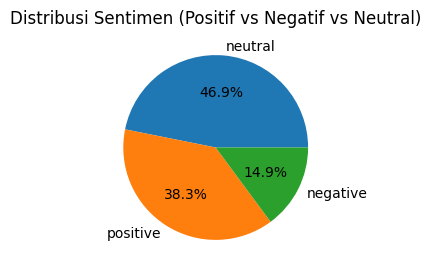

In [12]:
# pie chart polarity

sentiment_counts = review['polarity'].value_counts()

plt.figure(figsize=(3, 3))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Distribusi Sentimen (Positif vs Negatif vs Neutral)')
plt.show()

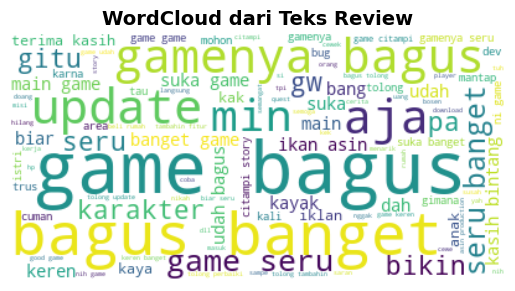

In [13]:
# Teks data
text = ' '.join(review['text_akhir'].astype(str).tolist())
# Membuat wordcloud
wordcloud = WordCloud(background_color='white').generate(text)
# Menampilkan WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud dari Teks Review", fontsize=14, fontweight='bold')
plt.show()

## Data Splitting dan Ekstraksi Fitur

Pada project ini, akan ada 8 skema percobaan pelatihan seperti berikut
- Pelatihan: XGBoost,    Ekstraksi Fitur: Bag of Words,    Pembagian Data: 70/30
- Pelatihan: XGBoost,    Ekstraksi Fitur: TF-IDF,    Pembagian Data: 80/20
- Pelatihan: Naive Bayes,    Ekstraksi Fitur: Bag of Words,    Pembagian Data: 70/30 
- Pelatihan: Naive Bayes,    Ekstraksi Fitur: TF-IDF,    Pembagian Data: 80/20
- Pelatihan: Logistic Regression,    Ekstraksi Fitur: Bag of Words,    Pembagian Data: 70/30 
- Pelatihan: Logistic Regression,    Ekstraksi Fitur: TF-IDF,    Pembagian Data: 80/20
- Pelatihan: SVM linear,    Ekstraksi Fitur: Bag of Words,    Pembagian Data: 70/30
- Pelatihan: SVM linear,    Ekstraksi Fitur: TF-IDF,    Pembagian Data: 80/20

In [15]:
# drop missing value
review = review.dropna(subset=['text_akhir'])

In [16]:
review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59789 entries, 0 to 67567
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Review                59789 non-null  object
 1   text_clean            59789 non-null  object
 2   text_casefoldingText  59789 non-null  object
 3   text_slangwords       59789 non-null  object
 4   text_tokenizingText   59789 non-null  object
 5   text_stopword         59789 non-null  object
 6   text_lemmatization    59789 non-null  object
 7   text_akhir            59789 non-null  object
 8   polarity_score        59789 non-null  int64 
 9   polarity              59789 non-null  object
dtypes: int64(1), object(9)
memory usage: 5.0+ MB


**Data yang digunakan dalam modeling sebanyak 59.789**

In [17]:
X = review['text_akhir']
y = review['polarity']

label_encoder = LabelEncoder()
# melakukan encoding pada label
y = label_encoder.fit_transform(y)

# membagi data menjadi 80% untuk training dan 20% untuk testing
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X, y, test_size=0.2, random_state=42)

# membagi data menjadi 70% untuk training dan 30% untuk testing
X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(X, y, test_size=0.3, random_state=42)

# ekstraksi fitur menggunakan TF-IDF
vectorizer_tfidf = TfidfVectorizer()

# TF-IDF untuk 80/20 split
X_train_80_tfidf = vectorizer_tfidf.fit_transform(X_train_80)
X_test_80_tfidf = vectorizer_tfidf.transform(X_test_80)

# ekstraksi fitur menggunakan BoW
vectorizer_bow = CountVectorizer()

# boW untuk 70/30 split
X_train_70_bow = vectorizer_bow.fit_transform(X_train_70)
X_test_70_bow = vectorizer_bow.transform(X_test_70)


print("\nTF-IDF - 80/20 Split")
print("Training Data Shape:", X_train_80_tfidf.shape)
print("Testing Data Shape:", X_test_80_tfidf.shape)

print("\nBag of Words (BoW) - 70/30 Split")
print("Training Data Shape:", X_train_70_bow.shape)
print("Testing Data Shape:", X_test_70_bow.shape)


TF-IDF - 80/20 Split
Training Data Shape: (47831, 41208)
Testing Data Shape: (11958, 41208)

Bag of Words (BoW) - 70/30 Split
Training Data Shape: (41852, 37639)
Testing Data Shape: (17937, 37639)


## Modeling

In [18]:
# ===================== XGBoost - Bag of Words =====================
xgb_model_bow = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model_bow.fit(X_train_70_bow, y_train_70)

xgb_train_pred_bow = xgb_model_bow.predict(X_train_70_bow)
xgb_test_pred_bow = xgb_model_bow.predict(X_test_70_bow)

xgb_bow_acc_train = accuracy_score(y_train_70, xgb_train_pred_bow)
xgb_bow_acc_test = accuracy_score(y_test_70, xgb_test_pred_bow)
print("XGBoost Train Accuracy (BoW):", xgb_bow_acc_train)
print("XGBoost Test Accuracy (BoW):", xgb_bow_acc_test)
print("======"*10)


# ===================== XGBoost - TF-IDF =====================
xgb_model_tfidf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model_tfidf.fit(X_train_80_tfidf, y_train_80)

xgb_train_pred_tfidf = xgb_model_tfidf.predict(X_train_80_tfidf)
xgb_test_pred_tfidf = xgb_model_tfidf.predict(X_test_80_tfidf)

xgb_tfidf_acc_train = accuracy_score(y_train_80, xgb_train_pred_tfidf)
xgb_tfidf_acc_test = accuracy_score(y_test_80, xgb_test_pred_tfidf)
print("XGBoost Train Accuracy (TF-IDF):", xgb_tfidf_acc_train)
print("XGBoost Test Accuracy (TF-IDF):", xgb_tfidf_acc_test)

XGBoost Train Accuracy (BoW): 0.8303067953741756
XGBoost Test Accuracy (BoW): 0.7746557395328093
XGBoost Train Accuracy (TF-IDF): 0.8501390311722523
XGBoost Test Accuracy (TF-IDF): 0.7791436695099515


In [19]:
# ===================== Naive Bayes - Bag of Words =====================
nb_model_bow = MultinomialNB()
nb_model_bow.fit(X_train_70_bow, y_train_70)

nb_train_pred_bow = nb_model_bow.predict(X_train_70_bow)  # Prediksi training
nb_test_pred_bow = nb_model_bow.predict(X_test_70_bow)

nb_bow_acc_train = accuracy_score(y_train_70, nb_train_pred_bow)
nb_bow_acc_test = accuracy_score(y_test_70, nb_test_pred_bow)
print("Naive Bayes Train Accuracy (BoW):", nb_bow_acc_train)
print("Naive Bayes Test Accuracy (BoW):", nb_bow_acc_test)
print("======"*10)

# ===================== Naive Bayes - TF-IDF =====================
nb_model_tfidf = MultinomialNB()
nb_model_tfidf.fit(X_train_80_tfidf, y_train_80)

nb_train_pred_tfidf = nb_model_tfidf.predict(X_train_80_tfidf)
nb_test_pred_tfidf = nb_model_tfidf.predict(X_test_80_tfidf)

nb_tfidf_acc_train = accuracy_score(y_train_80, nb_train_pred_tfidf)
nb_tfidf_acc_test = accuracy_score(y_test_80, nb_test_pred_tfidf)
print("Naive Bayes Train Accuracy (TF-IDF):", nb_tfidf_acc_train)
print("Naive Bayes Test Accuracy (TF-IDF):", nb_tfidf_acc_test)

Naive Bayes Train Accuracy (BoW): 0.8275351237694734
Naive Bayes Test Accuracy (BoW): 0.7074204159000947
Naive Bayes Train Accuracy (TF-IDF): 0.7625180322385064
Naive Bayes Test Accuracy (TF-IDF): 0.6777053018899482


In [20]:
# ===================== Logistic Regression - Bag of Words =====================
logreg_model_bow = LogisticRegression(max_iter=1000)
logreg_model_bow.fit(X_train_70_bow, y_train_70)

logreg_train_pred_bow = logreg_model_bow.predict(X_train_70_bow)
logreg_test_pred_bow = logreg_model_bow.predict(X_test_70_bow)

logreg_bow_acc_train = accuracy_score(y_train_70, logreg_train_pred_bow)
logreg_bow_acc_test = accuracy_score(y_test_70, logreg_test_pred_bow)
print("Logistic Regression Train Accuracy (BoW):", logreg_bow_acc_train)
print("Logistic Regression Test Accuracy (BoW):", logreg_bow_acc_test)
print("======"*10)

# ===================== Logistic Regression - TF-IDF =====================
logreg_model_tfidf = LogisticRegression(max_iter=1000)
logreg_model_tfidf.fit(X_train_80_tfidf, y_train_80)

logreg_train_pred_tfidf = logreg_model_tfidf.predict(X_train_80_tfidf)
logreg_test_pred_tfidf = logreg_model_tfidf.predict(X_test_80_tfidf)

logreg_tfidf_acc_train = accuracy_score(y_train_80, logreg_train_pred_tfidf)
logreg_tfidf_acc_test = accuracy_score(y_test_80, logreg_test_pred_tfidf)
print("Logistic Regression Train Accuracy (TF-IDF):", logreg_tfidf_acc_train)
print("Logistic Regression Test Accuracy (TF-IDF):", logreg_tfidf_acc_test)

Logistic Regression Train Accuracy (BoW): 0.9752699990442512
Logistic Regression Test Accuracy (BoW): 0.8827563137648436
Logistic Regression Train Accuracy (TF-IDF): 0.889025945516506
Logistic Regression Test Accuracy (TF-IDF): 0.8253888610135475


In [21]:
# ===================== SVM Linear - Bag of Words =====================
svm_model_bow = SVC(kernel='linear')
svm_model_bow.fit(X_train_70_bow, y_train_70)

svm_train_pred_bow = svm_model_bow.predict(X_train_70_bow)
svm_test_pred_bow = svm_model_bow.predict(X_test_70_bow)

svm_bow_acc_train = accuracy_score(y_train_70, svm_train_pred_bow)
svm_bow_acc_test = accuracy_score(y_test_70, svm_test_pred_bow)
print("SVM Train Accuracy (BoW):", svm_bow_acc_train)
print("SVM Test Accuracy (BoW):", svm_bow_acc_test)
print("======"*10)

# ===================== SVM Linear - TF-IDF =====================
svm_model_tfidf = SVC(kernel='linear')
svm_model_tfidf.fit(X_train_80_tfidf, y_train_80)

svm_train_pred_tfidf = svm_model_tfidf.predict(X_train_80_tfidf)
svm_test_pred_tfidf = svm_model_tfidf.predict(X_test_80_tfidf)

svm_tfidf_acc_train = accuracy_score(y_train_80, svm_train_pred_tfidf)
svm_tfidf_acc_test = accuracy_score(y_test_80, svm_test_pred_tfidf)
print("SVM Train Accuracy (TF-IDF):", svm_tfidf_acc_train)
print("SVM Test Accuracy (TF-IDF):", svm_tfidf_acc_test)

SVM Train Accuracy (BoW): 0.9896540189238269
SVM Test Accuracy (BoW): 0.9060600992362157
SVM Train Accuracy (TF-IDF): 0.927745604315193
SVM Test Accuracy (TF-IDF): 0.8499749121926744


## Inference / Testing

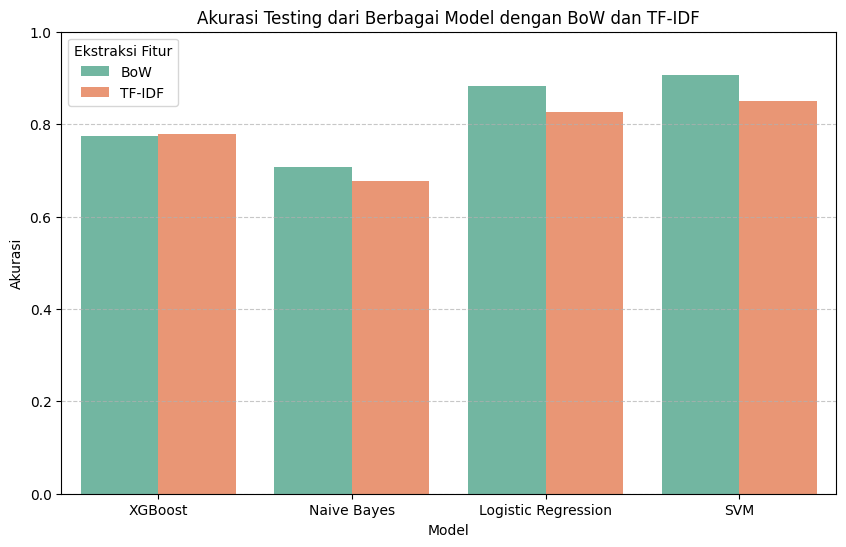

In [22]:
# data akurasi dari setiap model
models = ['XGBoost', 'Naive Bayes', 'Logistic Regression', 'SVM']
accuracy_bow = [xgb_bow_acc_test, nb_bow_acc_test, logreg_bow_acc_test, svm_bow_acc_test]
accuracy_tfidf = [xgb_tfidf_acc_test, nb_tfidf_acc_test, logreg_tfidf_acc_test, svm_tfidf_acc_test]

# membuat DataFrame untuk visualisasi
df = pd.DataFrame({
    'Model': models * 2,
    'Akurasi': accuracy_bow + accuracy_tfidf,
    'Ekstraksi Fitur': ['BoW'] * 4 + ['TF-IDF'] * 4
})

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Model', y='Akurasi', hue='Ekstraksi Fitur', palette='Set2')

plt.title("Akurasi Testing dari Berbagai Model dengan BoW dan TF-IDF")
plt.ylabel("Akurasi")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(title="Ekstraksi Fitur")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

**Insight**
- **Akurasi testing tertinggi adalah 90.6%** pada model SVM Bag of Words
- Akurasi tertinggi berikutnya adalah **88.2%** (Logistic Regression Bag of Words) dan **84.9%** (SVM TF-IDF)
- Untuk model Naive Bayes, Logistic Regression, dan SVM terdapat overfitting di mana akurasi training lebih tinggi daripada testing. Ini dapat dicegah dengan melakukan cross-validation
- Model Naive Bayes memiliki akurasi yang paling rendah, mungkin masih bisa ditingkatkan dengan hyperparameter tuning
- Akurasi model pada project ini kemungkinan bisa ditingkatkan lagi menggunakan model ensemble seperti voting (saya sudah mencoba nya namun memakan waktu komputasi yang terlalu lama) atau bisa juga menggunakan deep learning (juga memakan waktu komputasi yang terlalu lama walaupun sudah menggunakan gpu, kemungkinan karena banyaknya fitur)

In [23]:
# Contoh review baru yang ingin diuji
new_reviews = ["game bagus dan keren, saya suka", 
               "bagus tapi perlu ditingkatkan lagi",
               "buruk sekali, jelek, saya kecewa"]

# Transformasikan review ke dalam bentuk fitur (BoW)
new_reviews_bow = vectorizer_bow.transform(new_reviews)

# Prediksi menggunakan model SVM yang sudah dilatih
predictions = svm_model_bow.predict(new_reviews_bow)

sentiment_labels = label_encoder.inverse_transform(predictions)

for review, sentiment in zip(new_reviews, sentiment_labels):
    print(f"Review: \"{review}\" -> Sentimen: {sentiment}")

Review: "game bagus dan keren, saya suka" -> Sentimen: positive
Review: "bagus tapi perlu ditingkatkan lagi" -> Sentimen: neutral
Review: "buruk sekali, jelek, saya kecewa" -> Sentimen: negative
